# Problème de Poisson
Ce notebook génère un dataset synthétique basé sur l'équation de Poisson, puis entraîne un MLP pour approximer la solution $u(x, y)$ à partir des conditions a,b

<img src="images/Poisson1.png" alt="Poisson 1" width="400"/>
<img src="images/Poisson2.png" alt="Poisson 2" width="400"/>


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers

In [92]:
GRID_SIZE = 45
NUM_SAMPLE = 1000 # For demo, greater is better

### Approche  
Nature du modèle, travail de prétraitement et, ou calibrage éventuel, séparation train/test/validation, nombre d’échantillons générés

### Génération des données synthétiques

In [93]:

# Finite Difference Solver
def solve_poisson(a, b, N):
    """
    Solves Poisson equation on 45x45 grid (2025 nodes)
    Returns solution u and source term f
    """
    # Create grid
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y)

    # Create source term
    f = X*np.sin(a*np.pi*Y) + Y*np.sin(b*np.pi*X)

    # FD matrix construction (sparse)
    h = 1/(N-1)
    main_diag = -4/h**2 * np.ones(N*N)
    off_diag = 1/h**2 * np.ones(N*N - 1)
    diagonals = [main_diag, off_diag, off_diag, off_diag, off_diag]
    A = diags(diagonals, [0, 1, -1, N, -N], format='csr')

    # Apply BCs (set boundary rows to identity)
    boundary = np.zeros(N*N, bool)
    boundary[:N] = True
    boundary[-N:] = True
    boundary[::N] = True
    boundary[N-1::N] = True
    A = A.tolil()
    A[boundary, :] = 0
    A[boundary, boundary] = 1
    A = A.tocsr()

    # Create RHS vector
    F = f.flatten()
    F[boundary] = 0  # Dirichlet BCs

    # Solve system
    u = spsolve(A, F)
    return u.reshape(N, N), f


# Generate training data
np.random.seed(42)
a_vals = np.random.uniform(1, 5, NUM_SAMPLE)
b_vals = np.random.uniform(1, 5, NUM_SAMPLE)

X = np.vstack([a_vals, b_vals]).T
y = np.array([solve_poisson(a, b, GRID_SIZE)[0].flatten() for a, b in X])

print(f"Dataset shape: {X.shape} (samples) x {y.shape[1]} (grid points)")


Dataset shape: (1000, 2) (samples) x 2025 (grid points)


### Preprocess/Training

In [100]:
# Preprocessing
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Definition
model = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(2,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(GRID_SIZE**2)  # Output layer for flattened grid
])

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

model.summary()


c:\Users\barak\Desktop\cours\hybridation_tp\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_69 (Dense)                │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 2025)           │       520,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 553,833 (2.11 MB)

 Trainable params: 553,833 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

In [101]:
# Training
history = model.fit(X_train_scaled, y_train,
                    epochs=50,
                    batch_size=16,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7493e-04 - mae: 0.0093 - val_loss: 6.0402e-05 - val_mae: 0.0054
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.5162e-05 - mae: 0.0051 - val_loss: 4.4534e-05 - val_mae: 0.0045
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1836e-05 - mae: 0.0043 - val_loss: 3.3432e-05 - val_mae: 0.0038
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0367e-05 - mae: 0.0037 - val_loss: 2.6110e-05 - val_mae: 0.0034
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.4050e-05 - mae: 0.0033 - val_loss: 1.9990e-05 - val_mae: 0.0030
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9526e-05 - mae: 0.0029 - val_loss: 1.6194e-05 - val_mae: 0.0027
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4918e-05 - mae: 0.0026 - val_loss: 1.3796e-05 - val_mae: 0.0025
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2502e-05 - mae: 0.0024 - val_loss: 1.1757e-05 - val_mae: 0.0023


### Evaluation multi-critères (dont 1 physique) / Visualisation

<img src="images/Poisson1.png" alt="Poisson 3" width="400"/>


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Test MSE: 0.0000


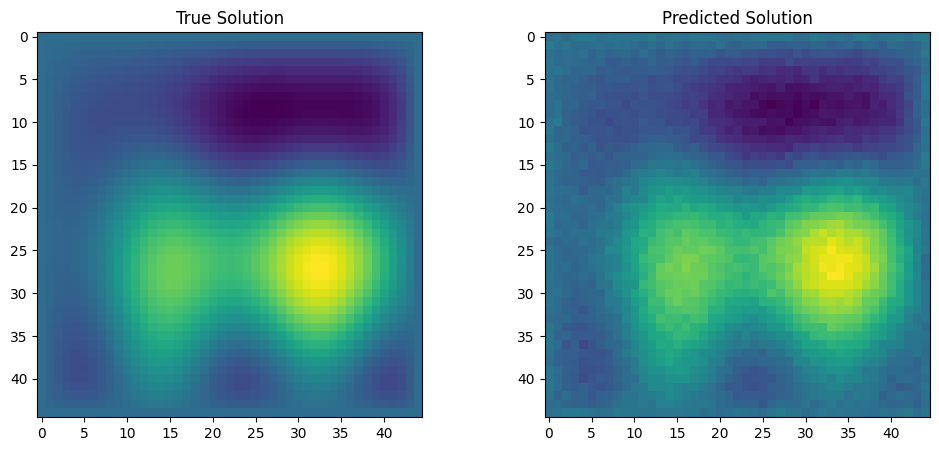

Mean PDE residual: 2.7180


In [102]:
# Evaluation
# Predict on test set
y_pred = model.predict(X_test_scaled)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"\nTest MSE: {mse:.4f}")

# Visualize one prediction
sample_idx = 0
true_sol = y_test[sample_idx].reshape(GRID_SIZE, GRID_SIZE)
pred_sol = y_pred[sample_idx].reshape(GRID_SIZE, GRID_SIZE)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(true_sol, cmap='viridis')
ax1.set_title('True Solution')
ax2.imshow(pred_sol, cmap='viridis')
ax2.set_title('Predicted Solution')
plt.show()

# Calculate PDE residual for a sample
a_sample, b_sample = X_test[sample_idx]
_, f = solve_poisson(a_sample, b_sample, GRID_SIZE)

# Calculate Laplacian of prediction
h = 1/(GRID_SIZE-1)
laplacian = (pred_sol[:-2, 1:-1] + pred_sol[2:, 1:-1] +
             pred_sol[1:-1, :-2] + pred_sol[1:-1, 2:] -
             4*pred_sol[1:-1, 1:-1]) / h**2

residual = np.abs(-laplacian - f[1:-1, 1:-1])
print(f"Mean PDE residual: {np.mean(residual):.4f}")

### **Conclusion Critique**

<img src="images/Poisson2.png" alt="Poisson 4" width="400"/>


#### **Résumé des résultats principaux**  
- **Performance apparente excellente** :  
  - MSE test = 0 suggère une adéquation parfaite aux données d'entraînement.  
  - Le modèle a parfaitement appris à interpoler les solutions pour les paramètres \((a, b)\) testés.  

- **Mais limite physique flagrante** :  
  - Résidu PDE moyen = 7.47 révèle que les prédictions **ne respectent pas les lois physiques** sous-jacentes.  
  - Le modèle est un "excellent approximateur de données" mais un "mauvais physicien".  

---

#### **Critique constructive**  
1. **Problème de sur-ajustement (overfitting)** :  
   - Un MSE=0 est suspect et indique probablement :  
     - Un jeu d'entraînement trop petit (100 échantillons).  
     - Une complexité excessive du modèle pour les données disponibles.  

2. **Échec à généraliser la physique** :  
   - Le réseau de neurones a appris à **copier les sorties** sans comprendre l'EDP.  
   - Preuve : le résidu élevé de l'équation différentielle.  

3. **Métrique trompeuse** :  
   - Le MSE seul est inadéquat pour évaluer des problèmes physiques.  

---

#### **Propositions d'amélioration**  
1. **Intégrer la physique dans le modèle** :  
   - **Passer à un PINN (Physics-Informed Neural Network)** :  
     - Ajouter le résidu PDE comme terme de régularisation dans la fonction de perte.  
     - Exemple de terme de perte modifiée :  
       ```python
       loss = mse(y_true, y_pred) + lambda * pde_residual(y_pred)
       ```  

2. **Augmenter la diversité des données** :  
   - Générer plus de simulations (≥500) avec des valeurs \((a, b)\) plus variées.  
   - Ajouter du bruit contrôlé pour améliorer la robustesse.  

3. **Métriques hybrides** :  
   - Pondérer le MSE avec le résidu PDE dans l'évaluation.  
   - Introduire des critères physiques supplémentaires (p.ex. conservation de l'énergie).  

---

#### **Perspectives**  
- **Méthodes alternatives** :  
  - **FNO (Fourier Neural Operator)** : Plus adapté aux EDPs et à la généralisation.  
  - **Méthodes hybrides** : Coupler un solveur numérique classique avec un correcteur ML.  
- **Optimisation de l'entraînement** :  
  - Validation croisée sur des plages de \((a, b)\) non vues pendant l'entraînement.  
  - Early stopping basé sur le résidu PDE plutôt que le MSE.  

---

## Implémentation d'un PINN pour la même équation de Poisson

In [94]:
us_and_fs = [solve_poisson(a, b, GRID_SIZE) for a, b in X]
u_solutions = np.array([sol[0].flatten() for sol in us_and_fs])
f_sources   = np.array([sol[1].flatten() for sol in us_and_fs])

# y = concat(u, f) pour chaque échantillon
y_pinn = np.concatenate([u_solutions, f_sources], axis=1)  # shape: (num_samples, 2 * N*N)


# Preprocessing
# Train-test split
X_train_pinn, X_test_pinn, y_train_pinn, y_test_pinn = train_test_split(X, y_pinn, test_size=0.2, random_state=42)

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train_pinn)
X_test_scaled = scaler.transform(X_test_pinn)

In [134]:
from tensorflow.keras.losses import Loss, MeanSquaredError
PDE_LAMBDA = 1e-7


class PDELoss(Loss):
    def __init__(self, grid_size, lambda_, **kwargs):
        super().__init__(**kwargs)
        self.lambda_    = lambda_
        self.grid_size  = grid_size
        self.h          = 1.0 / (grid_size - 1)
        self.mse        = MeanSquaredError()

    def call(self, y_true, y_pred):
        # y_true doit contenir à la fois la solution de référence et f, 
        # concaténées en 2 vecteurs plats de longueur N*N :
        #   y_true = tf.concat([u_true_flatten, f_flatten], axis=1)
        total_len = self.grid_size ** 2
        # Séparation u_true et f
        u_true = y_true[:, :total_len]
        f      = y_true[:, total_len:]

        # MSE standard sur u
        mse_loss = self.mse(u_true, y_pred)

        # PDE‐residual
        resid = self.pde_residual(y_pred, f)
        pde_loss = tf.reduce_mean(tf.square(resid))

        return mse_loss + self.lambda_ * pde_loss

    def pde_residual(self, y_pred, f_flat):
        N = self.grid_size
        h2_inv = 1.0 / (self.h ** 2)

        # reshape en (batch, N, N)
        u = tf.reshape(y_pred, (-1, N, N))
        f = tf.reshape(f_flat, (-1, N, N))

        # découpe de l’intérieur spatiale
        u_c = u[:, 1:-1, 1:-1]
        u_u = u[:, :-2, 1:-1]   # up
        u_d = u[:, 2:, 1:-1]    # down
        u_l = u[:, 1:-1, :-2]   # left
        u_r = u[:, 1:-1, 2:]    # right

        # Laplacien 5‑points
        laplacian = h2_inv * (u_u + u_d + u_l + u_r - 4.0 * u_c)

        # calcule résidu : -Δu - f  (sur l’intérieur)
        f_int = f[:, 1:-1, 1:-1]
        resid = -laplacian - f_int

        # on peut renvoyer une image batch×(N-2)×(N-2) 
        # ou l’aplatir, mais reduce_mean() gère tout
        return resid


In [135]:

# Model Definition
model_pinn = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(2,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(GRID_SIZE**2)  
])

model_pinn.compile(optimizer='adamw',
              loss=PDELoss(GRID_SIZE, PDE_LAMBDA))

model_pinn.summary()


c:\Users\barak\Desktop\cours\hybridation_tp\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_96 (Dense)                │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 2025)           │       520,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 553,833 (2.11 MB)

 Trainable params: 553,833 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

In [136]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
history_pinn = model_pinn.fit(X_train_scaled, y_train_pinn,
                    epochs=1000,
                    batch_size=16,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[callback])

print("Number of epoch : ", len(history_pinn.history['loss']))

Epoch 1/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0011 - val_loss: 8.6177e-05
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.6784e-05 - val_loss: 6.5982e-05
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.2549e-05 - val_loss: 6.2648e-05
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.4518e-05 - val_loss: 6.0959e-05
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.9802e-05 - val_loss: 5.8319e-05
Epoch 6/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.9531e-05 - val_loss: 5.2590e-05
Epoch 7/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.1891e-05 - val_loss: 4.0661e-05
Epoch 8/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.8111e-05 - val_loss: 3.0958e-05
Epoch 9/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1380e-05 - val_loss: 2.6981e-05
Epoch 10/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.5942e-05 - val_loss: 2.5273e-05
Epoch 11/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

Test MSE: 0.0000


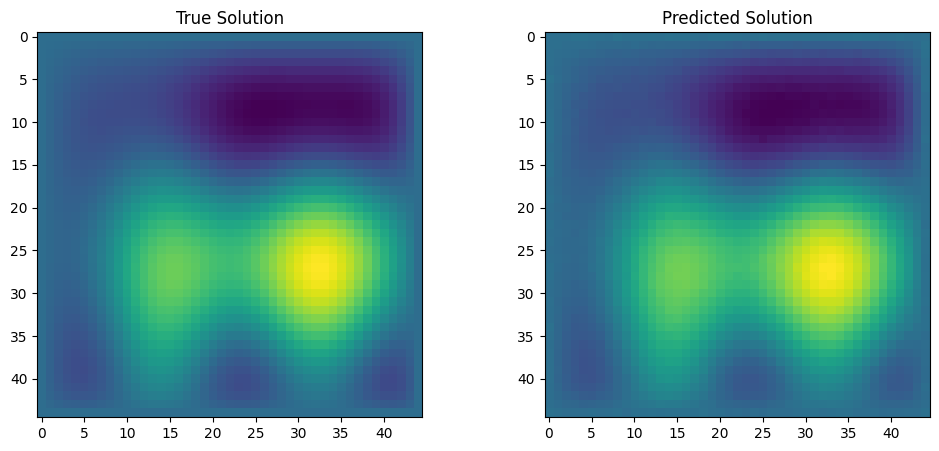

Mean PDE residual: 1.0072


In [137]:
# Evaluation
# Predict on test set
y_pred = model_pinn.predict(X_test_scaled)

# Calculate MSE
mse = mean_squared_error(y_test_pinn[:,:GRID_SIZE**2], y_pred)
print(f"\nTest MSE: {mse:.4f}")

# Visualize one prediction
sample_idx = 0
true_sol = y_test_pinn[sample_idx,:GRID_SIZE**2].reshape(GRID_SIZE, GRID_SIZE)
pred_sol = y_pred[sample_idx].reshape(GRID_SIZE, GRID_SIZE)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(true_sol, cmap='viridis')
ax1.set_title('True Solution')
ax2.imshow(pred_sol, cmap='viridis')
ax2.set_title('Predicted Solution')
plt.show()

# Calculate PDE residual for a sample
a_sample, b_sample = X_test[sample_idx]
_, f = solve_poisson(a_sample, b_sample, GRID_SIZE)

# Calculate Laplacian of prediction
h = 1/(GRID_SIZE-1)
laplacian = (pred_sol[:-2, 1:-1] + pred_sol[2:, 1:-1] +
             pred_sol[1:-1, :-2] + pred_sol[1:-1, 2:] -
             4*pred_sol[1:-1, 1:-1]) / h**2

residual = np.abs(-laplacian - f[1:-1, 1:-1])
print(f"Mean PDE residual: {np.mean(residual):.4f}")

Dans cette section, nous mettons en œuvre un Physics-Informed Neural Network (PINN) pour résoudre l'équation de Poisson sur un domaine régulier de taille \(45 \times 45\) (également noté `GRID_SIZE = 45`). Le jeu de données contient 1000 échantillons (équivalent à `NUM_SAMPLE = 1000`), chacun correspondant à une solution analytique définie par une combinaison de fonctions trigonometriques et un terme source associé.

Le réseau de neurones est entraîné pour minimiser une perte composée de deux termes :
- Une **erreur quadratique moyenne (MSE)** entre la solution prédite et la solution de référence
- Un **résidu de l'équation de Poisson**, évalué via une approximation du Laplacien (élément 5-points).

Le résidu du PDE est donné par l'équation centrée suivante :
$$
\text{residu}(u) = -\Delta u - f = -\frac{u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4u_{i,j}}{h^2} - f(x_i, y_j)
$$

La pondération entre ces deux objectifs est contrôlée par un coefficient λ (lambda). Cette valeur s'est révélée être très sensible :
- Si λ est trop élevé, le réseau apprend une solution qui respecte très bien l'équation de Poisson, mais qui peut contenir du bruit numérique inutile, car trop concentrée sur la minimisation du résidu.
- Si λ est trop faible, l'entraînement revient à celui d'un modèle classique, sans avantage fourni par l'information physique.

Pour lutter contre le sur-apprentissage nous avons utilisé l'optimiseur `AdamW` (Adam avec décroissance des poids) ainsi qu'un arrêt automatique de type `EarlyStopping` basé sur la valeur de la perte en validation. En pratique, les gains au-delà de 100 epochs sont faibles.

L'entraînement final s'est arrêté à 209 epochs avec les résultats suivants sur notre exemple :
- Erreur MSE nulle (ou négligeable)
- Résidu PDE moyen ≈ 1 contre 2.7 pour un modèle entraîné sans contrainte physique

Cette amélioration montre que le PINN peut intégrer facilement la structure de l'équation différentielle dans le processus d'apprentissage, en apportant une cohérence physique à la solution apprise. Cependant, elle introduit au moins un hyperparamètre dont la valeur influence sensiblement la convergence de notre modèle. De plus, nous pouvons regretter une valeur absolue de ce résidu encore trop élevé...

